
# HS300 — XGBoost Stock Selection × RSRS & T‑Sharpe Timing (Clean & Explained)

This notebook is a **clean, robust, and fully explained** version that builds a combined equity strategy for HS300 constituents:

**What you'll get**
- Load factor and price data with robust fallbacks.
- Train **XGBoost** to rank stocks from `factor_*` features.
- Construct a **market‑neutral selection** (long top p%, short bottom p%) with **turnover‑based fees applied only on rebalance days**.
- Compute timing overlays:
  - **RSRS (Rolling Regression Slope z-score)** with **quantile thresholds** (enter on 70%, exit on 30% by default).
  - **T‑Sharpe** (rolling Sharpe of benchmark).
- Build and compare strategies:
  - **Selection‑only** (Gross & Net)
  - **RSRS timing** (Gross & Net; timing-only fees on flips)
  - **T‑Sharpe timing** (Gross & Net; timing-only fees on flips)
  - **OR timing** (RSRS OR T‑Sharpe) (Gross & Net; timing-only fees on flips)
  - **Partial Timing**: first enter 100%, exit halves exposure, re‑enter restores to 100% (Gross & Net; timing-only fees proportional to exposure change)
- Plot **equity curves** and show a consolidated **performance table**.

> ⚙️ Change `REBALANCE_DAYS` to 5 / 10 / 20 etc. to rebalance less often — selection fees will automatically follow that cadence.


## 1) Configuration

In [66]:

# Paths: try Windows drive first, then local /mnt/data copies as fallback.
WINDOWS_BASE = "F:/Code_Crunch/test"
LINUX_BASE   = "/mnt/data"

FACTOR_CANDIDATES = [
    f"{WINDOWS_BASE}/merged_factors.csv",
    f"{LINUX_BASE}/merged_factors.csv",
]
PRICE_CANDIDATES = [
    f"{WINDOWS_BASE}/hs300_2020_2025_dynamic.csv",
    f"{LINUX_BASE}/hs300_2020_2025_dynamic.csv",
]
BENCH_CANDIDATES = [
    f"{WINDOWS_BASE}/HS300_daily_2014_2024.csv",
    f"{LINUX_BASE}/HS300_daily_2014_2024.csv",
]

# Columns in your files
DATE_COL = "trade_date"
TICKER_COL = "ts_code"

# Modeling / Portfolio
TRAIN_TEST_SPLIT_RATIO = 0.7
PORTFOLIO_PERCENTILE = 10   # long top p%, short bottom p%
REBALANCE_DAYS = 1          # ⬅ change to 5/10/20, etc.
STARTING_CAPITAL = 100_000

# RSRS (quantile thresholds)
RSRS_WINDOW = 18
RSRS_ZSCORE_WINDOW = 600
RSRS_ENTER_Q = 0.70     # enter if RSRS z > 70th percentile
RSRS_EXIT_Q  = 0.30     # exit  if RSRS z < 30th percentile

# T‑Sharpe (timing on benchmark quality)
TSHARPE_LOOKBACK = 60
TSHARPE_ENTER = -0.1
TSHARPE_EXIT  = -0.1

# Trading costs
FEE_PER_SIDE = 0.0005        # 5 bps commission/impact per side
SLIPPAGE_PER_SIDE = 0.0002   # 2 bps slippage per side
FEE_PER_SIDE_TOTAL = FEE_PER_SIDE + SLIPPAGE_PER_SIDE


## 2) Imports & Helper Functions

In [67]:

import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
warnings.filterwarnings("ignore")

# ML
try:
    import xgboost as xgb
except Exception as e:
    raise RuntimeError("xgboost is required for this notebook.") from e

# RSRS requires OLS
import statsmodels.api as sm

# Optional performance helper (if provided)
sys.path.append("/mnt/data")
try:
    from performance import Strategy_performance
except Exception as _e:
    Strategy_performance = None
    print("Note: performance.py not found. Performance table may be skipped.", _e)

def choose_existing(candidates):
    """Pick the first existing path from a candidate list."""
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"No existing file found among: {candidates}")

def normalize_keys(df: pd.DataFrame, date_col: str, ticker_col: str) -> pd.DataFrame:
    """Standardize date & ticker columns for safe merging."""
    df = df.copy()
    df[date_col] = (
        df[date_col].astype(str).str.replace(r"[^0-9]", "", regex=True).str.slice(0,8).str.zfill(8)
    )
    df[ticker_col] = df[ticker_col].astype(str).str.strip()
    return df

def parse_date(series: pd.Series) -> pd.Series:
    """Parse date from YYYYMMDD (or fallback to best-effort)."""
    try:
        return pd.to_datetime(series, format="%Y%m%d", errors="raise")
    except Exception:
        return pd.to_datetime(series, errors="coerce")


## 3) Load & Prepare Data

In [68]:

# Pick files
factor_path = choose_existing(FACTOR_CANDIDATES)
price_path  = choose_existing(PRICE_CANDIDATES)
bench_path  = choose_existing(BENCH_CANDIDATES)
print("Using factor:", factor_path)
print("Using prices:", price_path)
print("Using benchmark:", bench_path)

# Load raw
df_f = pd.read_csv(factor_path)
df_p = pd.read_csv(price_path)
df_b = pd.read_csv(bench_path)
print(df_b.head())
# Normalize keys
df_f = normalize_keys(df_f, DATE_COL, TICKER_COL)
df_p = normalize_keys(df_p, DATE_COL, TICKER_COL)

# Merge to a panel (Date, Ticker) index
df_m = pd.merge(df_f, df_p, on=[TICKER_COL, DATE_COL], how="inner", suffixes=("", "_p")).drop_duplicates([TICKER_COL, DATE_COL])
df_m[DATE_COL] = parse_date(df_m[DATE_COL])

# Choose "Close": prefer explicit close; else next-day pre_close; else fallback
close = None
for c in ["close", "Close"]:
    if c in df_m.columns:
        close = pd.to_numeric(df_m[c], errors="coerce")
        break
if close is None and "pre_close" in df_m.columns:
    # next day's pre_close as effective "close" for today's return calc
    close = df_m.groupby(TICKER_COL)["pre_close"].shift(-1)
if close is None:
    for c in ["price", "last", "open"]:
        if c in df_m.columns:
            close = pd.to_numeric(df_m[c], errors="coerce")
            break
if close is None:
    raise ValueError("Could not determine a Close series from merged data.")
df_m["Close"] = close

panel = df_m.rename(columns={DATE_COL:"Date", TICKER_COL:"Ticker"}).set_index(["Date","Ticker"]).sort_index()

# Factor columns
factor_cols = [c for c in panel.columns if str(c).startswith("factor_")]
if not factor_cols:
    raise ValueError("No 'factor_*' columns found.")

# Benchmark (use provided close)
df_b = df_b.copy()
df_b[DATE_COL] = parse_date(df_b[DATE_COL].astype(str).str.replace(r"[^0-9]","", regex=True).str.slice(0,8))
b_close = None
for c in ["close","Close"]:
    if c in df_b.columns:
        b_close = pd.to_numeric(df_b[c], errors="coerce")
        break
if b_close is None:
    raise ValueError("Benchmark file must include a 'close' column.")
df_b = df_b.assign(Close=b_close).rename(columns={DATE_COL:"Date"}).set_index("Date").sort_index()
bm_daily_ret = df_b["Close"].pct_change().fillna(0.0)

print("Panel shape:", panel.shape)
print("Benchmark span:", bm_daily_ret.index.min().date(), "→", bm_daily_ret.index.max().date())


Using factor: F:/Code_Crunch/test/merged_factors.csv
Using prices: F:/Code_Crunch/test/hs300_2020_2025_dynamic.csv
Using benchmark: F:/Code_Crunch/test/HS300_daily_2014_2024.csv
     ts_code  trade_date     close      open      high       low  pre_close  \
0  000300.SH    20140102  2321.978  2323.433  2325.991  2310.653   2330.026   
1  000300.SH    20140103  2290.779  2311.968  2314.836  2280.887   2321.978   
2  000300.SH    20140106  2238.637  2286.371  2286.371  2229.334   2290.779   
3  000300.SH    20140107  2238.001  2222.306  2246.791  2218.647   2238.637   
4  000300.SH    20140108  2241.911  2240.635  2262.584  2228.418   2238.001   

   change  pct_chg         vol        amount  
0  -8.048  -0.3454  45194291.0  4.901221e+07  
1 -31.199  -1.3436  59782645.0  5.773971e+07  
2 -52.142  -2.2762  66300403.0  5.997936e+07  
3  -0.636  -0.0284  43753103.0  4.256565e+07  
4   3.910   0.1747  51348854.0  5.069149e+07  
Panel shape: (363028, 96)
Benchmark span: 2014-01-02 → 2024-12-31

## 4) Define Supervised Target & Train/Test Split

In [69]:

# Target: will stock outperform cross-sectional median return over next REBALANCE_DAYS?
REBAL = max(1, int(REBALANCE_DAYS))

df2 = panel.copy()
df2["Future_Return"] = df2.groupby(level="Ticker")["Close"].shift(-REBAL) / df2["Close"] - 1
median_cs = df2.groupby(level="Date")["Future_Return"].transform("median")
df2["Target"] = (df2["Future_Return"] > median_cs).astype(int)

# Keep rows where features + target + price are present
required = factor_cols + ["Target","Close"]
clean = df2.dropna(subset=required)

# Split by date (avoid leakage)
unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
split_idx = max(1, min(int(len(unique_dates)*TRAIN_TEST_SPLIT_RATIO), len(unique_dates)-1))
split_date = unique_dates[split_idx]

train = clean[clean.index.get_level_values("Date") < split_date]
test  = clean[clean.index.get_level_values("Date") >= split_date]

print("Train period:", train.index.get_level_values("Date").min().date(), "→", train.index.get_level_values("Date").max().date())
print("Test  period:",  test.index.get_level_values("Date").min().date(),  "→", test.index.get_level_values("Date").max().date())

X_train, y_train = train[factor_cols], train["Target"]
X_test  = test[factor_cols]


Train period: 2020-04-03 → 2023-08-07
Test  period: 2023-08-08 → 2024-12-30


## 5) Train XGBoost & Inspect Feature Importances

,Feature,Importance
0,factor_intraday_return,0.018412
1,factor_mg_rz_bal_diff_norm,0.017862
2,factor_auction_total_vol_share,0.016835
3,factor_lower_shadow,0.016746
4,factor_mf_main_amt_ratio_z60,0.016400
5,factor_vol_spike,0.016360
6,factor_macd_dea,0.016184
7,factor_mf_net_amt_ratio_sum_20d,0.016154
8,factor_mf_main_amt_ratio_sum_20d,0.016079
9,factor_mg_rz_net_norm,0.016054


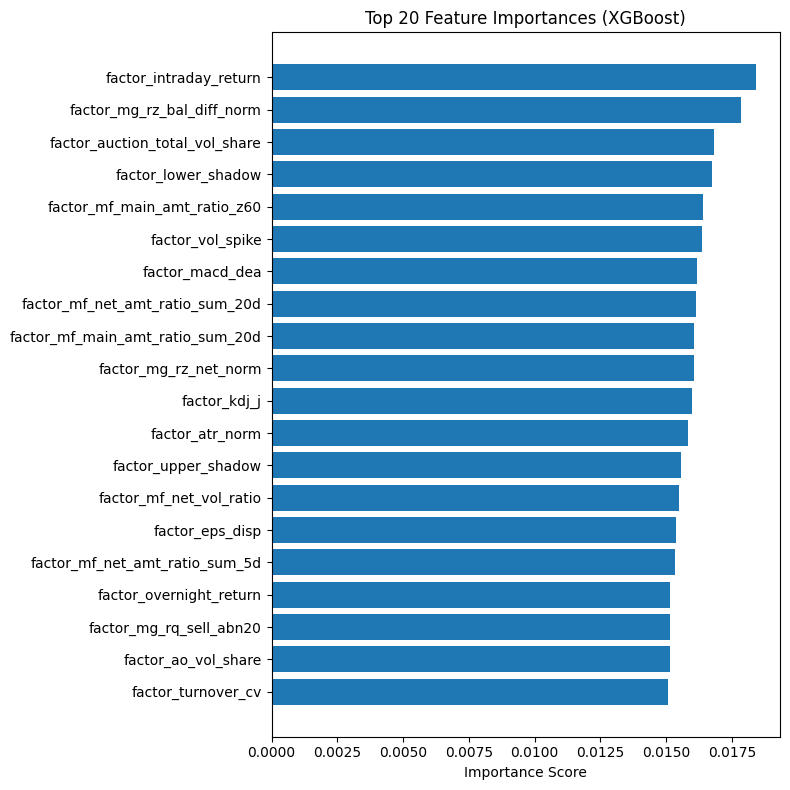

In [70]:

# Simple validation split from training period
vi = int(len(X_train)*TRAIN_TEST_SPLIT_RATIO)
X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

# Fit with early stopping when available (keeps code version-portable)
fitted = False
try:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); fitted=True
except TypeError:
    try:
        es = xgb.callback.EarlyStopping(rounds=50, save_best=True)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[es], verbose=False); fitted=True
    except TypeError:
        pass
if not fitted:
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

# Show & plot importances
fi = pd.DataFrame({"Feature": factor_cols, "Importance": model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
display(fi.head(30))

def plot_feature_importance(fi, top_n=20):
    top = fi.head(top_n)
    plt.figure(figsize=(8, max(4, top_n*0.4)))
    plt.barh(list(reversed(top["Feature"].tolist())), list(reversed(top["Importance"].tolist())))
    plt.xlabel("Importance Score"); plt.title(f"Top {top_n} Feature Importances (XGBoost)")
    plt.tight_layout(); plt.show()

plot_feature_importance(fi, top_n=20)


## 6) Build Selection‑Only Long/Short (Gross)

In [71]:

# Rank by predicted probability on test dates; long top p%, short bottom p%.
proba = model.predict_proba(X_test)[:,1]
pred = X_test.copy(); pred["prob"] = proba

close_panel = panel["Close"].unstack(level="Ticker")
test_dates = sorted(pred.index.get_level_values("Date").unique())

all_rets = []                 # daily L/S returns
baskets_by_date = {}          # store long/short baskets to compute turnover-based fees later

#REBAL = max(1, int(REBALANCE_DAYS)) --- IGNORE ---
for i in range(0, max(0, len(test_dates)-1), REBAL):
    d0 = test_dates[i]
    d1 = test_dates[min(i+REBAL, len(test_dates)-1)]
    row = pred.loc[d0]
    if isinstance(row, pd.Series): row = row.to_frame().T
    if row.shape[0] < 2: continue

    sorted_row = row.sort_values("prob", ascending=False)
    n = len(sorted_row)
    k = max(1, int(n * PORTFOLIO_PERCENTILE/100.0))
    long_tks  = sorted_row.head(k).index.tolist()
    short_tks = sorted_row.tail(k).index.tolist()
    baskets_by_date[d0] = {"long": set(long_tks), "short": set(short_tks)}

    cols = list(set(long_tks).union(set(short_tks)))
    try:
        price_slice = close_panel.loc[d0:d1, cols]
        stock_rets = price_slice.pct_change().iloc[1:]
        if stock_rets.empty: continue
        long_ret  = stock_rets[long_tks].mean(axis=1)
        short_ret = stock_rets[short_tks].mean(axis=1)
        ls = (long_ret - short_ret) / 2.0   # market‑neutral, equal gross each side
        ls.name = "LS"
        all_rets.append(ls)
    except Exception:
        continue

sel_rets = (pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float))
print("Selection-only observations:", len(sel_rets))


Selection-only observations: 338


## 7) Apply Turnover‑based Fees on Rebalance Days (Selection‑Only Net)

In [72]:
def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
    """
    Robust turnover and fee estimation for equal-weight L/S portfolios.
    Handles missing dates gracefully.
    """
    fee = pd.Series(0.0, index=sel_rets_index)
    prev_long, prev_short = set(), set()

    for d0 in sorted(baskets_by_date.keys()):
        current = baskets_by_date[d0]
        long_tks, short_tks = current["long"], current["short"]
        k = max(1, k_per_side)

        entries_long = len(long_tks - prev_long); exits_long = len(prev_long - long_tks)
        entries_short = len(short_tks - prev_short); exits_short = len(prev_short - short_tks)
        gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k

        fee_decimal = gross_turnover * fee_per_side_total

        # find first valid trading day >= d0
        later_dates = sel_rets_index[sel_rets_index >= d0]
        if len(later_dates) > 0:
            fee.loc[later_dates[0]] += fee_decimal

        prev_long, prev_short = long_tks, short_tks

    return fee

# --- Safety checks ---
if baskets_by_date:
    first_date = sorted(baskets_by_date.keys())[0]
    k_per_side = len(baskets_by_date[first_date]["long"])
else:
    k_per_side = 1

# --- Compute fees safely ---
sel_fee_series = compute_selection_fees_turnover(
    baskets_by_date=baskets_by_date,
    sel_rets_index=sel_rets.index,
    k_per_side=k_per_side,
    fee_per_side_total=FEE_PER_SIDE_TOTAL
)

selection_only_gross = sel_rets.copy()
selection_only_net = selection_only_gross - sel_fee_series.fillna(0.0)


## 8) RSRS Timing (Quantile Thresholds)

In [73]:

# def rsrs_signal_quantile(high: pd.Series, low: pd.Series,
#                          enter_q=0.7, exit_q=0.3,
#                          window=18, zscore_window=600):
#     """
#     RSRS computes rolling OLS slope beta_t of High ~ Low over `window`,
#     then z‑scores beta_t over `zscore_window`.
#     Enter when z > enter quantile; exit when z < exit quantile.
#     """
#     df0 = pd.DataFrame({"high": high, "low": low}).dropna()
#     betas, idxs = [], []
#     for i in range(window, len(df0)+1):
#         sub = df0.iloc[i-window:i]
#         X = sm.add_constant(sub["low"].values)
#         y = sub["high"].values
#         try:
#             b = sm.OLS(y, X).fit().params[1]
#         except Exception:
#             b = np.nan
#         betas.append(b); idxs.append(sub.index[-1])
#     beta = pd.Series(betas, index=idxs).dropna()
#     z = (beta - beta.rolling(zscore_window).mean()) / beta.rolling(zscore_window).std()
#     z = z.replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     enter_thr = z.quantile(enter_q)
#     exit_thr  = z.quantile(exit_q)
#     sig = pd.Series(0, index=z.index, dtype=int); state = 0
#     for dt, v in z.items():
#         if state==0 and v > enter_thr: state = 1
#         elif state==1 and v < exit_thr: state = 0
#         sig.loc[dt] = state
#     return sig, z, enter_thr, exit_thr

# # Build high/low series (fallback to benchmark ±0.5% if missing)
# if ("high" in df_m.columns) and ("low" in df_m.columns):
#     hs_high = df_m.groupby(DATE_COL)["high"].mean()
#     hs_low  = df_m.groupby(DATE_COL)["low"].mean()
# else:
#     bc = df_b["Close"]
#     hs_high = bc * (1 + 0.005)
#     hs_low  = bc * (1 - 0.005)
# hs_high.index = pd.to_datetime(hs_high.index); hs_low.index = pd.to_datetime(hs_low.index)

# rsrs_sig_full, rsrs_z, rsrs_enter_thr, rsrs_exit_thr = rsrs_signal_quantile(
#     hs_high, hs_low, enter_q=RSRS_ENTER_Q, exit_q=RSRS_EXIT_Q,
#     window=RSRS_WINDOW, zscore_window=RSRS_ZSCORE_WINDOW
# )
# # Align RSRS signal to selection dates
# rsrs_sig = rsrs_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 9) T‑Sharpe Timing (Rolling Sharpe of Benchmark)

In [74]:

# def rolling_sharpe(ret: pd.Series, lookback=60):
#     def _sh(x):
#         x = np.asarray(x); sd = x.std(ddof=0)
#         if sd == 0: return np.nan
#         return x.mean()/sd
#     return ret.rolling(lookback).apply(_sh, raw=True)

# def tsharpe_signal(ret: pd.Series, lookback=60, enter=0.2, exit=-0.1, plot=True):
#     rs = rolling_sharpe(ret, lookback).fillna(0.0)
#     sig = pd.Series(0, index=rs.index, dtype=int); state = 0
#     for dt, v in rs.items():
#         if state==0 and v > enter: state = 1
#         elif state==1 and v < exit: state = 0
#         sig.loc[dt] = state

#     if plot:
#         plt.figure(figsize=(12,5))
#         plt.plot(rs.index, rs.values, label=f"Rolling Sharpe ({lookback}d)")
#         plt.axhline(y=enter, linestyle="--", label=f"Enter {enter}")
#         plt.axhline(y=exit, linestyle="--", label=f"Exit {exit}")
#         plt.title("Rolling Sharpe Ratio (T‑Sharpe Timing)")
#         plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.legend(); plt.grid(True); plt.show()

#         summary = {"mean": float(rs.mean()), "std": float(rs.std()), "min": float(rs.min()),
#                    "25%": float(rs.quantile(0.25)), "50%": float(rs.quantile(0.5)),
#                    "75%": float(rs.quantile(0.75)), "max": float(rs.max())}
#         print("Rolling Sharpe Summary:", summary)
#     return sig, rs

# tsh_sig_full, tsh_rs = tsharpe_signal(bm_daily_ret, TSHARPE_LOOKBACK, TSHARPE_ENTER, TSHARPE_EXIT, plot=True)
# tsh_sig = tsh_sig_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)


## 10) Timing Combinations & Timing‑only Fees

In [75]:

# # Gross returns with timing overlays
# sel_rsrs_gross = sel_rets * rsrs_sig
# sel_tsh_gross  = sel_rets * tsh_sig

# combo_sig = ((rsrs_sig==1) | (tsh_sig==1)).astype(int)  # OR logic (change to & for AND)
# sel_or_gross = sel_rets * combo_sig

# # Timing‑only fees: charge costs when timing changes state (0↔1)
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# rsrs_flip = rsrs_sig.diff().abs().fillna(0.0)
# tsh_flip  = tsh_sig.diff().abs().fillna(0.0)
# or_flip   = combo_sig.diff().abs().fillna(0.0)

# sel_rsrs_net = sel_rsrs_gross - rsrs_flip * fee_per_flip
# sel_tsh_net  = sel_tsh_gross  - tsh_flip  * fee_per_flip
# sel_or_net   = sel_or_gross   - or_flip   * fee_per_flip


## 11) Partial Timing (Halve on Exit, Restore on Enter)

In [76]:

# # Rule:
# # - First enter (0→1): exposure = 100%
# # - Exit (1→0): exposure *= 0.5
# # - Re‑enter (0→1 again): exposure = 100%

# exposure = 0.0; exposures, rets_partial = [], []
# for dt, sig in combo_sig.items():
#     if exposure == 0 and sig == 1:
#         exposure = 1.0
#     elif exposure > 0 and sig == 0:
#         exposure = exposure * 0.7
#     elif exposure < 1.0 and sig == 1:
#         exposure = 1.0
#     exposures.append(exposure)
#     rets_partial.append(sel_rets.loc[dt] * exposure)

# exposure_series = pd.Series(exposures, index=combo_sig.index, name="Exposure")
# sel_with_partial_timing = pd.Series(rets_partial, index=combo_sig.index, name="PartialTiming")

# # Timing‑only cost proportional to exposure change (Δexposure)
# delta_exp = exposure_series.diff().abs().fillna(0.0)
# sel_with_partial_timing_net = sel_with_partial_timing - delta_exp * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)


## 12) Plot Equity Curves (Gross & Net)

In [77]:

# def plot_equity(series_dict, title="Equity Curves"):
#     fig, ax = plt.subplots(figsize=(12,7))
    
#     # Predefined colors by strategy group
#     color_map = {
#         "Selection": "tab:blue",
#         "RSRS": "tab:green",
#         "T-Sharpe": "tab:red",
#         "OR": "tab:purple",
#         "Partial": "tab:orange",
#         "Benchmark": "black"
#     }
    
#     # Plot with style (gross=solid, net=dashed)
#     for name, rets in series_dict.items():
#         if rets is None or len(rets)==0: 
#             continue
#         eq = (1+rets).cumprod()*STARTING_CAPITAL
        
#         # choose color by keyword
#         c = None
#         for key in color_map:
#             if key in name:
#                 c = color_map[key]
#                 break
#         if c is None:
#             c = "gray"
        
#         # solid line for gross, dashed for net
#         style = "-" if "(gross)" in name else "--" if "(net)" in name else "-"
        
#         ax.plot(eq.index, eq.values, label=name, color=c, linestyle=style, linewidth=1.8)
    
#     ax.set_title(title)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Portfolio Value")
#     ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x,_: f"${x:,.0f}"))
#     ax.legend(loc="upper left", bbox_to_anchor=(1,1))  # place legend outside plot
#     ax.grid(True)
#     plt.tight_layout()
#     plt.show()

# bm_aligned = bm_daily_ret.reindex(sel_rets.index).fillna(0.0)

# plot_equity({
#     "Selection only (gross)": selection_only_gross,
#     "Selection only (net)": selection_only_net,
#     "RSRS timing (gross)": sel_rsrs_gross,
#     "RSRS timing (net)": sel_rsrs_net,
#     "T-Sharpe timing (gross)": sel_tsh_gross,
#     "T-Sharpe timing (net)": sel_tsh_net,
#     "OR timing (gross)": sel_or_gross,
#     "OR timing (net)": sel_or_net,
#     #"Partial timing (gross)": sel_with_partial_timing,
#     "Partial timing (net)": sel_with_partial_timing_net,
#     "SP500 Benchmark": bm_aligned
# }, title="Equity Curves — Selection & Timing (Gross/Net)")



## 13) Performance Table

In [78]:

# perf_df = pd.DataFrame({
#     "selection_only_gross": selection_only_gross,
#     "selection_only_net": selection_only_net,
#     "rsrs_gross": sel_rsrs_gross,
#     "rsrs_net": sel_rsrs_net,
#     "tsharpe_gross": sel_tsh_gross,
#     "tsharpe_net": sel_tsh_net,
#     "or_gross": sel_or_gross,
#     "or_net": sel_or_net,
#     "partial_gross": sel_with_partial_timing,
#     "partial_net": sel_with_partial_timing_net,
#     "benchmark": bm_aligned
# }).dropna(how="all")

# if Strategy_performance is not None:
#     Strategy_performance(perf_df, mark_benchmark="benchmark", periods="daily")
# else:
#     display(perf_df.tail())


In [79]:
def summarize_strategies(returns_dict, risk_free_rate=0.0, periods_per_year=252):
    """
    Summarize performance metrics for multiple return series.
    
    Parameters
    ----------
    returns_dict : dict of {name: pd.Series}
        Each value should be a daily return series.
    risk_free_rate : float
        Daily risk-free rate (default 0).
    periods_per_year : int
        Number of trading periods per year (default 252).
    
    Returns
    -------
    summary : pd.DataFrame
        Table with Annual Return, Volatility, Sharpe, Max Drawdown.
    """
    rows = []
    for name, rets in returns_dict.items():
        if rets is None or len(rets)==0:
            continue
        rets = rets.dropna()
        if len(rets)==0: continue
        
        # cumulative growth
        cum = (1+rets).cumprod()
        
        # metrics
        ann_ret = (cum.iloc[-1]**(periods_per_year/len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret - risk_free_rate) / vol if vol>0 else np.nan
        running_max = cum.cummax()
        dd = (cum/running_max - 1).min() *100
        
        rows.append({
            "Strategy": name,
            "Annual Return %": ann_ret,
            "Volatility %": vol,
            "Sharpe": sharpe,
            "Max Drawdown %": dd
        })
    
    return pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)

# # ---- Call the function on all strategies ----
# summary = summarize_strategies({
#     "Selection Gross": selection_only_gross,
#     "Selection Net": selection_only_net,
#     "RSRS Gross": sel_rsrs_gross,
#     "RSRS Net": sel_rsrs_net,
#     "TSharpe Gross": sel_tsh_gross,
#     "TSharpe Net": sel_tsh_net,
#     "OR Gross": sel_or_gross,
#     "OR Net": sel_or_net,
#     "Partial Gross": sel_with_partial_timing,
#     "Partial Net": sel_with_partial_timing_net,
#     "Benchmark": bm_aligned
# })

# # Pretty print
# pd.options.display.float_format = "{:.2%}".format
# display(summary)


## 14) Macro-adjusted strategy

In [80]:
# # === New Cell: Macro-Adjusted T-Sharpe using PMI, CPI, and M1 (no overwrite) ===
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # ------------------------------------------------------------
# # 0) Robust path handling for your macro file
# #    (tries your Windows paths first, then /mnt/data fallback)
# # ------------------------------------------------------------
# macro_candidates = [
#     Path("F:/Code_Crunch/test/macroeconomics_CN.xlsx"),
# ]
# macro_path = next((p for p in macro_candidates if p.exists()), None)
# if macro_path is None:
#     raise FileNotFoundError("Could not find 'macroeconomics_CN.xlsx' in any known location.")

# # ------------------------------------------------------------
# # 1) Load monthly macro data and coerce to numeric
# # ------------------------------------------------------------
# macro_m = pd.read_excel(macro_path, index_col=0)
# macro_m.index = pd.to_datetime(macro_m.index, errors="coerce")
# macro_m = macro_m[macro_m.index.notna()]

# # Coerce all to numeric (handles %, commas)
# for c in macro_m.columns:
#     macro_m[c] = pd.to_numeric(
#         macro_m[c].astype(str).str.replace("%","").str.replace(",",""),
#         errors="coerce"
#     )

# # Keep only expected columns
# expected_cols = ["PMI", "CPI", "M1"]
# missing = [c for c in expected_cols if c not in macro_m.columns]
# if missing:
#     raise KeyError(f"Missing required macro columns in {macro_path.name}: {missing}. "
#                    f"Found columns: {list(macro_m.columns)}")

# macro_m = macro_m[expected_cols].copy()

# # ------------------------------------------------------------
# # 2) Z-score standardization (monthly)
# # ------------------------------------------------------------
# macro_std_m = (macro_m - macro_m.mean()) / macro_m.std()

# # Composite macro score:
# #   + M1 (liquidity)    -> boost exposure
# #   + PMI (momentum)    -> boost exposure
# #   - CPI (inflation)   -> reduce exposure
# macro_std_m["macro_score"] = (
#     0.4 * macro_std_m["M1"]
#   - 0.3 * macro_std_m["CPI"]
#   + 0.3 * macro_std_m["PMI"]
# )

# # ------------------------------------------------------------
# # 3) Align monthly → daily → T-Sharpe index
# #     Your notebook defines: tsh_rs (rolling Sharpe series)
# # ------------------------------------------------------------
# if 'tsh_rs' not in globals():
#     raise RuntimeError("Expected 'tsh_rs' (rolling Sharpe series) not found. "
#                        "Run the T-Sharpe cell first to create tsh_rs.")

# # Resample monthly to daily by forward-fill, then align to tsh_rs index
# macro_daily = macro_std_m.resample("D").ffill()
# macro_on_tsh = macro_daily.reindex(tsh_rs.index).ffill()
# macro_on_tsh["macro_score"] = macro_on_tsh["macro_score"].fillna(0.0)

# # ------------------------------------------------------------
# # 4) Build macro-adjusted T-Sharpe series and timing signal
# #     Use your existing thresholds: TSHARPE_ENTER / TSHARPE_EXIT
# # ------------------------------------------------------------
# alpha = 0.5  # sensitivity factor; tune 0.3–0.8 if you like
# tsh_rs_adj = tsh_rs * (1 + alpha * macro_on_tsh["macro_score"])

# def tsharpe_signal_from_series(rs_series: pd.Series, enter: float, exit: float) -> pd.Series:
#     """State machine on a precomputed Sharpe series to get a 0/1 timing signal."""
#     sig = pd.Series(0, index=rs_series.index, dtype=int)
#     state = 0
#     for dt, v in rs_series.items():
#         if state == 0 and v > enter:
#             state = 1
#         elif state == 1 and v < exit:
#             state = 0
#         sig.loc[dt] = state
#     return sig

# # Use your configured thresholds
# tsh_sig_adj_full = tsharpe_signal_from_series(
#     tsh_rs_adj, enter=TSHARPE_ENTER, exit=TSHARPE_EXIT
# )

# # Align adjusted timing to selection return index
# tsh_sig_adj = tsh_sig_adj_full.reindex(sel_rets.index).ffill().fillna(0).astype(int)

# # ------------------------------------------------------------
# # 5) Plots: original vs adjusted T-Sharpe series
# # ------------------------------------------------------------
# plt.figure(figsize=(12,6))
# plt.plot(tsh_rs.index, tsh_rs.values,  label="Original T-Sharpe (series)", linewidth=1.4)
# plt.plot(tsh_rs_adj.index, tsh_rs_adj.values, label="Macro-Adjusted T-Sharpe (series)", linewidth=2.0, alpha=0.9)
# plt.axhline(TSHARPE_ENTER, linestyle="--", color="tab:green",  label=f"Enter {TSHARPE_ENTER}")
# plt.axhline(TSHARPE_EXIT,  linestyle="--", color="tab:red",    label=f"Exit  {TSHARPE_EXIT}")
# plt.title("Original vs Macro-Adjusted T-Sharpe (Series-Level)")
# plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.grid(True); plt.legend()
# plt.show()

# # ------------------------------------------------------------
# # 6) Strategy returns using adjusted timing (gross & net)
# #     Mirrors your existing timing-cost model:
# #       sel_tsh_gross  = sel_rets * tsh_sig
# #       sel_tsh_net    = sel_tsh_gross - (flips * fee_per_flip)
# # ------------------------------------------------------------
# # Gross (adjusted)
# sel_tsh_gross_adj = sel_rets * tsh_sig_adj

# # Timing flip costs (use your existing fee model)
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# tsh_flip_adj = tsh_sig_adj.diff().abs().fillna(0.0)

# sel_tsh_net_adj = sel_tsh_gross_adj - tsh_flip_adj * fee_per_flip

# # ------------------------------------------------------------
# # 7) Equity curve comparison (original vs adjusted)
# #     We DO NOT overwrite your existing variables (sel_tsh_gross, sel_tsh_net, etc.)
# # ------------------------------------------------------------
# def plot_equity_curves(series_dict, title):
#     fig, ax = plt.subplots(figsize=(12,7))
#     for name, rets in series_dict.items():
#         if rets is None or len(rets) == 0:
#             continue
#         eq = (1 + rets).cumprod() * STARTING_CAPITAL
#         ax.plot(eq.index, eq.values, label=name)
#     ax.set_title(title)
#     ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
#     ax.legend(); ax.grid(True)
#     plt.show()

# plot_equity_curves({
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
# }, title="Equity — T-Sharpe Timing: Original vs Macro-Adjusted (Net)")

# # (Optional) If you want to include selection-only and OR strategies for context:
# plot_equity_curves({
#     "Selection only (net)": selection_only_net,
#     "RSRS timing (net)": sel_rsrs_net,
#     "Original T-Sharpe (net)": sel_tsh_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "OR timing (net)": sel_or_net,
# }, title="Equity — All Timing Variants (Net)")


In [81]:
# # ---- Call the function on all strategies ----
# summary = summarize_strategies({
#     "Selection Net": selection_only_net,
#     "Macro-Adjusted T-Sharpe (net)": sel_tsh_net_adj,
#     "RSRS Net": sel_rsrs_net,
#     "TSharpe Net": sel_tsh_net,
#     "OR Net": sel_or_net,
#     "Partial Net": sel_with_partial_timing_net,
#     "Benchmark": bm_aligned
# })

# # Pretty print
# pd.options.display.float_format = "{:.2%}".format
# display(summary)

In [82]:
# # === New Cell: Compare Original vs Macro-Adjusted T-Sharpe Partial Strategy ===
# import matplotlib.pyplot as plt

# # 1) Build partial strategies (combine selection + RSRS + T-Sharpe)
# #    Your existing partial strategy likely multiplies all timing signals.
# #    For safety we reconstruct both explicitly here.

# # Original T-Sharpe partial (as in previous notebook logic)
# partial_sig_orig = (tsh_sig & rsrs_sig).astype(int)  # logical AND of RSRS & T-Sharpe
# partial_gross_orig = sel_rets * partial_sig_orig
# partial_net_orig   = partial_gross_orig - partial_sig_orig.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# # Macro-adjusted T-Sharpe partial strategy
# partial_sig_adj = (tsh_sig_adj & rsrs_sig).astype(int)
# partial_gross_adj = sel_rets * partial_sig_adj
# partial_net_adj   = partial_gross_adj - partial_sig_adj.diff().abs().fillna(0) * 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)

# # 2) Plot comparison of equity curves
# def plot_equity(series_dict, title="Equity Comparison: Partial Strategy (Original vs Macro-Adjusted)"):
#     fig, ax = plt.subplots(figsize=(12,7))
#     for name, rets in series_dict.items():
#         if rets is None or len(rets)==0: 
#             continue
#         eq = (1 + rets).cumprod() * STARTING_CAPITAL
#         ax.plot(eq.index, eq.values, label=name)
#     ax.set_title(title)
#     ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value")
#     ax.legend(); ax.grid(True)
#     plt.show()

# plot_equity({
#     "Partial Strategy (Original T-Sharpe)": partial_net_orig,
#     "Partial Strategy (Macro-Adjusted T-Sharpe)": partial_net_adj,
# })

# # 3) Optional: quick performance summary
# def summary_stats(series):
#     ann_return = (1 + series).prod() ** (252 / len(series)) - 1
#     vol = series.std() * (252 ** 0.5)
#     sharpe = ann_return / vol if vol != 0 else 0
#     return {"Ann.Return": f"{ann_return:.2%}", "Volatility": f"{vol:.2%}", "Sharpe": f"{sharpe:.2f}"}

# print("Performance summary (net returns):")
# print("Original Partial:", summary_stats(partial_net_orig))
# print("Macro-Adjusted Partial:", summary_stats(partial_net_adj))


In [83]:
# # 1) Is T-Sharpe truly always on after your threshold change?
# print("tsh_sig values:", tsh_sig.value_counts(dropna=False).to_dict())
# print("Number of flips (tsh):", int(tsh_sig.diff().abs().fillna(0).sum()))

# # 2) Are you accidentally plotting OR/Partial instead of pure T-Sharpe selection?
# print("OR sig flips:", int(((rsrs_sig==1) | (tsh_sig==1)).astype(int).diff().abs().fillna(0).sum()))

# # 3) Fees actually charged
# print("Selection turnover fee total:", float(sel_fee_series.fillna(0).sum()))
# fee_per_flip = 2.0 * (FEE_PER_SIDE + SLIPPAGE_PER_SIDE)
# print("Timing flip fee total (tsh):", float((tsh_sig.diff().abs().fillna(0) * fee_per_flip).sum()))


# # 4) Exposure stats for Partial if used
# try:
#     print("Partial exposure stats:", exposure.describe())
# except Exception:
#     pass

# # 5) Fairness check: compare benchmark vs “benchmark masked by T-Sharpe”
# aligned_index = sel_rets.index.union(bm_daily_ret.index)
# bm_aligned = bm_daily_ret.reindex(aligned_index).fillna(0)
# tsh_aligned = tsh_sig.reindex(aligned_index).ffill().fillna(1)
# bm_masked_by_tsh = bm_aligned * tsh_aligned


# #bm_masked_by_tsh = bm_daily_ret.reindex(tsh_sig.index).fillna(0) * tsh_sig
# bm_eq = (1 + bm_daily_ret).cumprod()
# bm_masked_eq = (1 + bm_masked_by_tsh).cumprod()
# print("Benchmark final multiple:", float(bm_eq.iloc[-1]))
# print("Benchmark masked by T-Sharpe final multiple:", float(bm_masked_eq.iloc[-1]))


In [84]:
# print("bm_daily_ret index length:", len(bm_daily_ret))
# print("tsh_sig index length:", len(tsh_sig))
# print("Overlap length:", len(bm_daily_ret.index.intersection(tsh_sig.index)))
# print("Overlap ratio:", len(bm_daily_ret.index.intersection(tsh_sig.index)) / len(bm_daily_ret))


## 16) Another strategy to rebalance

### Long-Only Strategy: Rebalance Comparison (1, 5, 22)

Build long-only portfolios from the XGBoost probabilities, compare gross vs net (with turnover-based fees) for different rebalance periods, and plot alongside the HS300 benchmark.

In [93]:
# === strategy_pipeline_open_only_with_alpha_beta_fixed.py ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False


# ============================================================
# 工具函数
# ============================================================
def _get_train_ratio(default_val: float = 0.7) -> float:
    try:
        return float(TRAIN_TEST_SPLIT_RATIO)
    except NameError:
        return float(default_val)


# ============================================================
# 1. 数据拆分（严格开盘逻辑）
# ============================================================
def create_train_test_split(panel: pd.DataFrame,
                            factor_cols: list,
                            rebalance_days: int = 1,
                            train_test_ratio: Optional[float] = None):
    if train_test_ratio is None:
        train_test_ratio = _get_train_ratio(0.7)

    REBAL = max(1, int(rebalance_days))
    df2 = panel.copy()
    df2.columns = df2.columns.str.lower()

    if "open" not in df2.columns:
        raise ValueError("panel 必须包含 'open' 列。")
    if not isinstance(df2.index, pd.MultiIndex) or list(df2.index.names) != ["Date", "Ticker"]:
        raise ValueError("panel 的 MultiIndex 必须为 ['Date','Ticker']。")

    df2["future_return"] = df2.groupby(level="Ticker")["open"].shift(-REBAL) / df2["open"] - 1
    median_cs = df2.groupby(level="Date")["future_return"].transform("median")
    df2["target"] = (df2["future_return"] > median_cs).astype(int)
    df2[factor_cols] = df2.groupby(level="Ticker")[factor_cols].shift(1)
    clean = df2.dropna(subset=list(factor_cols) + ["target", "open"])

    unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
    split_idx = max(1, min(int(len(unique_dates) * train_test_ratio), len(unique_dates) - 1))
    split_date = unique_dates[split_idx]

    train = clean[clean.index.get_level_values("Date") < split_date]
    test = clean[clean.index.get_level_values("Date") >= split_date]
    X_train, y_train = train[factor_cols], train["target"]
    X_test = test[factor_cols]

    print("Train period:", train.index.get_level_values("Date").min().date(), "→",
          train.index.get_level_values("Date").max().date())
    print("Test  period:", test.index.get_level_values("Date").min().date(),  "→",
          test.index.get_level_values("Date").max().date())
    print("✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.")

    return train, test, X_train, y_train, X_test


# ============================================================
# 2. 模型训练
# ============================================================
def train_xgb_model(X_train, y_train, factor_cols, train_test_ratio=None):
    import xgboost as xgb
    if train_test_ratio is None:
        train_test_ratio = _get_train_ratio(0.7)
    vi = int(len(X_train) * float(train_test_ratio))
    vi = max(1, min(vi, len(X_train) - 1))
    X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
    X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )
    fitted = False
    try:
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
        fitted = True
    except Exception:
        model.fit(X_tr, y_tr, verbose=False)
    return model


# ============================================================
# 3. 回测逻辑（滞后一日信号 + 开盘交易）
# ============================================================
def run_backtest(model, panel, X_test, portfolio_percentile=10, rebalance_days=1, mode="ls"):
    REBAL = max(1, int(rebalance_days))
    panel.columns = panel.columns.str.lower()
    open_panel = panel["open"].unstack(level="Ticker")

    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    pred = X_test.copy(); pred["prob"] = proba
    test_dates = sorted(pred.index.get_level_values("Date").unique())
    if len(test_dates) < 2: return pd.Series([], dtype=float), {}

    all_rets, baskets_by_date = [], {}
    for i in tqdm(range(1, len(test_dates)), desc=f"{mode.upper()} Backtest") if _HAS_TQDM else range(1, len(test_dates)):
        signal_date = pd.Timestamp(test_dates[i - 1])
        trade_date = pd.Timestamp(test_dates[i])
        next_date_i = min(i + REBAL, len(test_dates) - 1)
        next_date = pd.Timestamp(test_dates[next_date_i])
        row = pred.loc[signal_date]
        if isinstance(row, pd.Series): row = row.to_frame().T
        if row.shape[0] < 1: continue
        sorted_row = row.sort_values("prob", ascending=False)
        k = max(1, int(len(sorted_row) * (portfolio_percentile / 100.0)))
        long_tks = sorted_row.head(k).index.tolist()
        short_tks = sorted_row.tail(k).index.tolist() if mode == "ls" else []
        baskets_by_date[trade_date] = {"long": set(long_tks), "short": set(short_tks)}
        cols = list(set(long_tks).union(set(short_tks)))
        if not cols: continue
        try:
            opens = open_panel.loc[trade_date:next_date, cols]
            if opens.shape[0] < 2: continue
            stock_rets = opens.pct_change().iloc[1:]
            if stock_rets.empty: continue
            long_ret = stock_rets[long_tks].mean(axis=1) if long_tks else pd.Series(0, index=stock_rets.index)
            short_ret = stock_rets[short_tks].mean(axis=1) if short_tks else pd.Series(0, index=stock_rets.index)
            daily = (long_ret - short_ret) / 2.0 if mode == "ls" else long_ret
            all_rets.append(daily)
        except Exception: continue
    sel_rets = pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float)
    sel_rets = sel_rets[~sel_rets.index.duplicated(keep="first")]
    return sel_rets, baskets_by_date


# ============================================================
# 4. 手续费计算
# ============================================================
def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
    sel_rets_index = pd.DatetimeIndex(sel_rets_index).sort_values()
    fee = pd.Series(0.0, index=sel_rets_index)
    prev_long, prev_short = set(), set()
    for d0 in sorted(baskets_by_date.keys()):
        cur = baskets_by_date[d0]
        long_tks, short_tks = set(cur["long"]), set(cur["short"])
        k = max(1, int(k_per_side))
        entries_long = len(long_tks - prev_long)
        exits_long = len(prev_long - long_tks)
        entries_short = len(short_tks - prev_short)
        exits_short = len(prev_short - short_tks)
        gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k
        fee_decimal = gross_turnover * fee_per_side_total
        d0 = pd.Timestamp(d0)
        later_dates = sel_rets_index[sel_rets_index >= d0]
        if len(later_dates) > 0:
            fee.loc[later_dates[0]] += fee_decimal
        prev_long, prev_short = long_tks, short_tks
    return fee


# ============================================================
# 5. 绘图 + 汇总
# ============================================================
def _plot_equity_dict(results_dict, benchmark_returns: Optional[pd.Series], title):
    plt.figure(figsize=(12, 6))
    all_series = [s.dropna() for s in results_dict.values() if len(s) > 0]
    if not all_series:
        print("没有可绘制的策略序列。"); return
    union_index = pd.Index(sorted(set().union(*[s.index for s in all_series])))
    name_map = {"1d": "daily", "5d": "weekly", "20d": "monthly", "22d": "monthly"}
    for name, rets in results_dict.items():
        if len(rets) == 0: continue
        eq = (1 + rets.reindex(union_index).fillna(0)).cumprod()
        plt.plot(eq.index, eq.values, label=name_map.get(name, name))
    if benchmark_returns is not None and len(benchmark_returns) > 0:
        b = benchmark_returns.reindex(union_index).fillna(0)
        plt.plot(b.index, (1 + b).cumprod().values, label="benchmark", linestyle="--", color="gray")
    plt.title(title); plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Rebalance frequency", loc="best"); plt.tight_layout(); plt.show()


# ============================================================
# 6. 绩效汇总
# ============================================================
def summarize_strategies(returns_dict, benchmark_returns=None, periods_per_year=252):
    rows = []
    for name, rets in returns_dict.items():
        if len(rets) == 0: continue
        rets = rets.dropna()
        cum = (1 + rets).cumprod()
        ann_ret = (cum.iloc[-1] ** (periods_per_year / len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret / vol) if vol > 0 else np.nan
        dd = (cum / cum.cummax() - 1).min() * 100
        rows.append({"Strategy": name, "Annual Return %": ann_ret,
                     "Volatility %": vol, "Sharpe": sharpe, "Max Drawdown %": dd})
    if benchmark_returns is not None:
        rets = benchmark_returns.dropna()
        cum = (1 + rets).cumprod()
        ann_ret = (cum.iloc[-1] ** (periods_per_year / len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret / vol) if vol > 0 else np.nan
        dd = (cum / cum.cummax() - 1).min() * 100
        rows.append({"Strategy": "Benchmark", "Annual Return %": ann_ret,
                     "Volatility %": vol, "Sharpe": sharpe, "Max Drawdown %": dd})
    df = pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)
    display(df)
    return df


# ============================================================
# 7. 修复版：Alpha / Beta 计算
# ============================================================
# ============================================================
# 改进版 compute_alpha_beta：使用 statsmodels OLS（含显著性）
# ===========================================================
# ============================================================
# 7. 改进版：Alpha / Beta 计算（带单位自检 + OLS 一致表格）
# ============================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

def _ensure_decimal_scale(s: pd.Series, name: str) -> pd.Series:
    """将可能是百分比单位的序列（例如 1.2 表示 1.2%）
       自动转换为十进制（0.012）。依据：中位绝对值 > 0.2 视为百分比单位。"""
    s = pd.to_numeric(s, errors="coerce")
    if s.dropna().abs().median() > 0.2:   # 经验阈值：>20% 基本可以判定是百分比单位
        print(f"🛠️  序列 {name} 似乎是百分比单位，已自动 /100 转为十进制。")
        s = s / 100.0
    return s

def compute_alpha_beta(results_dict, benchmark_returns, rf_csv_path=None):
    """
    === 最终无歧义版 compute_alpha_beta ===
    功能：
      ✅ 自动识别 Bloomberg / Wind / 自定义 格式的无风险利率文件；
      ✅ 自动检测利率单位（百分比 or 十进制）；
      ✅ 自动处理日期列 ("DATE", "date", 第一列)；
      ✅ 用 statsmodels.OLS 回归计算 alpha、beta、t 值、p 值、R²；
      ✅ 输出与回归摘要一致的汇总表；
      ✅ 自动打印单位诊断与转换过程，防止错误。

    回归模型：
        (r_i - r_f) = α + β (r_m - r_f) + ε
    """

    # =====================================================
    # 1️⃣ 读取无风险利率文件（若提供）
    # =====================================================
    if rf_csv_path:
        rf_raw = pd.read_csv(rf_csv_path)
        print(f"📂 已读取无风险利率文件: {rf_csv_path} (共 {len(rf_raw)} 行)")

        # 自动识别日期列
        date_col = None
        for c in rf_raw.columns:
            if "date" in c.lower():
                date_col = c
                break
        if date_col is not None:
            rf_raw[date_col] = pd.to_datetime(rf_raw[date_col])
            rf_raw = rf_raw.set_index(date_col)
        else:
            rf_raw.index = pd.to_datetime(rf_raw.iloc[:, 0])
            rf_raw = rf_raw.drop(rf_raw.columns[0], axis=1)

        # 自动检测数值列
        cand = [c for c in rf_raw.columns if rf_raw[c].astype(str).str.match(r"^[\d\.,%-]+$").any()]
        if not cand:
            cand = [rf_raw.columns[-1]]
        col = cand[0]

        rf = rf_raw[col].astype(str).str.replace("%", "", regex=False).str.replace(",", "", regex=False)
        rf = pd.to_numeric(rf, errors="coerce").dropna()
        print(f"🧭 检测到无风险利率列: {col}")

        # 自动判断单位：若中位数 > 1，则说明是百分比单位
        median_val = rf.median()
        if median_val > 1:
            print(f"🛠️ 检测到 RF 单位为百分比（例如 {median_val:.2f}%），自动 /100 转为十进制。")
            rf = rf / 100.0
        else:
            print(f"✅ 检测到 RF 单位为十进制（例如 {median_val:.4f}），无需除以 100。")

        # 转为日化
        rf = rf / 252.0
        rf = rf.sort_index().ffill()
        print(f"✅ 无风险利率读取成功，共 {len(rf)} 条记录。示例: 年化≈{median_val:.2f} → 日化≈{rf.iloc[0]:.6f}")
    else:
        rf = pd.Series(0.0, index=benchmark_returns.index)
        print("⚠️ 未提供无风险利率文件，默认 rf=0。")

    # =====================================================
    # 2️⃣ 单位检查函数
    # =====================================================
    def _ensure_decimal_scale(s: pd.Series, name: str) -> pd.Series:
        s = pd.to_numeric(s, errors="coerce")
        if s.dropna().abs().median() > 0.2:
            print(f"🛠️ {name} 似乎为百分比单位，自动 /100。")
            s = s / 100.0
        return s

    # 检查 benchmark 单位
    bench = _ensure_decimal_scale(pd.Series(benchmark_returns), "Benchmark")

    # =====================================================
    # 3️⃣ 对每个策略计算 Alpha/Beta
    # =====================================================
    rows = []
    for name, rets in results_dict.items():
        if rets is None or len(rets) == 0:
            continue

        strat = _ensure_decimal_scale(pd.Series(rets), f"Strategy[{name}]")

        # 对齐数据
        aligned = pd.concat([strat.rename("strategy"),
                             bench.rename("benchmark"),
                             rf.rename("rf")],
                            axis=1, join="inner").dropna()

        if len(aligned) < 30:
            print(f"⚠️ 数据太少，跳过 {name} ({len(aligned)} 条样本)")
            continue

        # 打印诊断信息
        ms, ss = aligned["strategy"].mean(), aligned["strategy"].std()
        mb, sb = aligned["benchmark"].mean(), aligned["benchmark"].std()
        mrf = aligned["rf"].mean()
        print(f"\n🔎 {name} 量纲检查: "
              f"mean(strategy)={ms:.6f}, std(strategy)={ss:.6f}; "
              f"mean(bench)={mb:.6f}, std(bench)={sb:.6f}; mean(rf)={mrf:.6f}")

        # 计算超额收益
        aligned["excess_strategy"]  = aligned["strategy"]  - aligned["rf"]
        aligned["excess_benchmark"] = aligned["benchmark"] - aligned["rf"]

        # OLS 回归
        X = sm.add_constant(aligned["excess_benchmark"])
        y = aligned["excess_strategy"]
        model = sm.OLS(y, X).fit()

        alpha_day = model.params["const"]
        beta = model.params["excess_benchmark"]
        r2 = model.rsquared

        # 年化（线性 & 几何）
        alpha_annual_linear = alpha_day * 252.0
        alpha_annual_geom = (1 + alpha_day) ** 252 - 1

        rows.append({
            "Strategy": name,
            "Alpha (daily)": alpha_day,
            "Alpha (annual %, linear)": alpha_annual_linear * 100,
            "Alpha (annual %, geom)": alpha_annual_geom * 100,
            "Beta": beta,
            "Alpha t-value": model.tvalues["const"],
            "Beta t-value": model.tvalues["excess_benchmark"],
            "Alpha p-value": model.pvalues["const"],
            "Beta p-value": model.pvalues["excess_benchmark"],
            "R²": r2,
            "Samples": len(aligned)
        })

        # 打印回归摘要（单策略）
        print(f"\n📈 {name} CAPM 回归摘要：")
        print(model.summary())

    # =====================================================
    # 4️⃣ 汇总结果表
    # =====================================================
    df = pd.DataFrame(rows).set_index("Strategy")

    # 美化格式
    df_fmt = df.copy()
    for col, fmt in [
        ("Alpha (daily)", "{:.6f}"),
        ("Alpha (annual %, linear)", "{:.2f}"),
        ("Alpha (annual %, geom)", "{:.2f}"),
        ("Beta", "{:.3f}"),
        ("Alpha t-value", "{:.2f}"),
        ("Beta t-value", "{:.2f}"),
        ("Alpha p-value", "{:.3e}"),
        ("Beta p-value", "{:.3e}"),
        ("R²", "{:.3f}")
    ]:
        df_fmt[col] = df[col].map(lambda x: fmt.format(x))

    print("\n=== 📈 CAPM Alpha/Beta Summary (Auto Unit Detection, OLS-Consistent) ===")
    display(df_fmt.sort_values("Alpha (annual %, linear)", ascending=False))

    return df



# ============================================================
# 8. 主函数
# ============================================================
def run_rebalance_comparison(panel, factor_cols, benchmark_returns,
                             rebalance_list=[1, 5, 20],
                             portfolio_percentile=10,
                             fee_per_side_total=0.001,
                             mode="ls",
                             rf_csv_path=None):
    results_gross, results_net = {}, {}
    for REBAL in rebalance_list:
        train, test, X_train, y_train, X_test = create_train_test_split(panel, factor_cols, rebalance_days=REBAL)
        model = train_xgb_model(X_train, y_train, factor_cols)
        sel_rets, baskets = run_backtest(model, panel, X_test, portfolio_percentile, REBAL, mode)
        results_gross[f"{REBAL}d"] = sel_rets
        k_per_side = len(baskets[next(iter(baskets))]["long"]) if baskets else 1
        fee_series = compute_selection_fees_turnover(baskets, sel_rets.index, k_per_side, fee_per_side_total)
        results_net[f"{REBAL}d"] = sel_rets - fee_series.fillna(0)

    _plot_equity_dict(results_gross, benchmark_returns, f"{mode.upper()} — No Fees (Strict OPEN-based)")
    _plot_equity_dict(results_net, benchmark_returns, f"{mode.upper()} — With Fees (fee={fee_per_side_total:.4f})")

    print("\n=== 📊 Performance Summary (No Fees) ===")
    summarize_strategies(results_gross, benchmark_returns)
    print("\n=== 📊 Performance Summary (With Fees) ===")
    summarize_strategies(results_net, benchmark_returns)

    compute_alpha_beta(results_net, benchmark_returns, rf_csv_path=rf_csv_path)
    return results_gross, results_net

Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 439.08it/s]


Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 362.44it/s]


Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 446.54it/s]


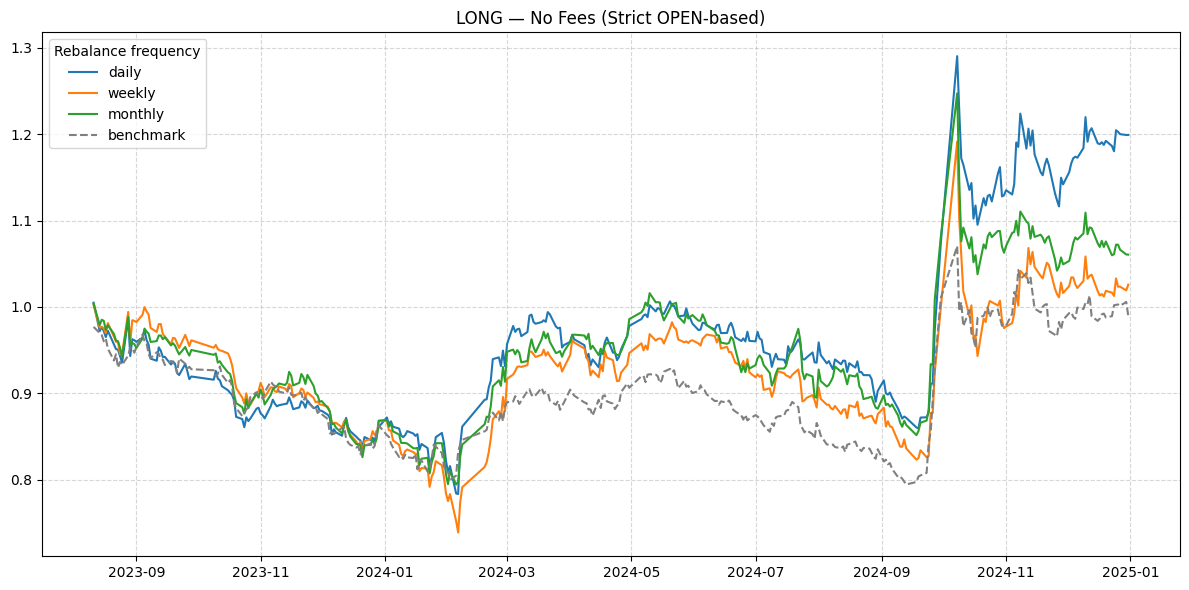

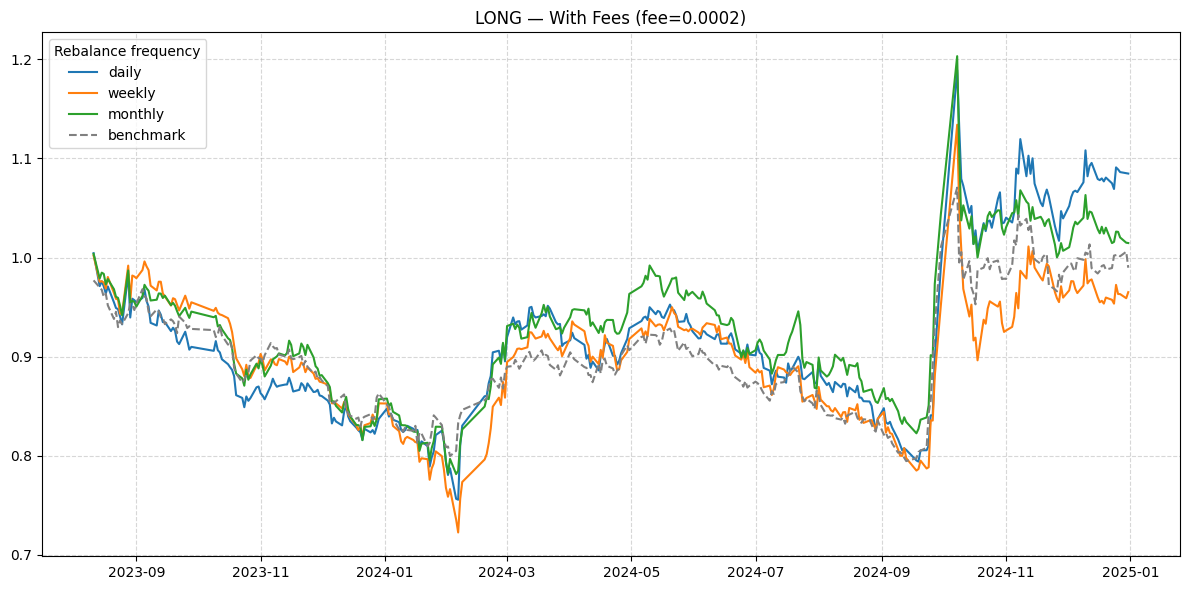


=== 📊 Performance Summary (No Fees) ===


,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
1d,14.538953,29.536569,0.492236,-22.026305
22d,4.497070,26.420868,0.170209,-20.846491
5d,1.927960,28.791761,0.066962,-26.252639
Benchmark,-0.838420,19.422218,-0.043168,-20.536413



=== 📊 Performance Summary (With Fees) ===


,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
1d,6.272778,29.532048,0.212406,-24.765054
22d,1.094243,26.417231,0.041422,-22.127932
Benchmark,-0.838420,19.422218,-0.043168,-20.536413
5d,-2.620760,28.786282,-0.091042,-27.873743


📂 已读取无风险利率文件: 10Y_CN_Treasury.csv (共 1394 行)
🧭 检测到无风险利率列: Risk Free rate
🛠️ 检测到 RF 单位为百分比（例如 2.73%），自动 /100 转为十进制。
✅ 无风险利率读取成功，共 1394 条记录。示例: 年化≈2.73 → 日化≈0.000126

🔎 1d 量纲检查: mean(strategy)=0.000406, std(strategy)=0.018603; mean(bench)=0.000044, std(bench)=0.012270; mean(rf)=0.000093

📈 1d CAPM 回归摘要：
                            OLS Regression Results                            
Dep. Variable:        excess_strategy   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     54.21
Date:                 周二, 28 10月 2025   Prob (F-statistic):           1.41e-12
Time:                        14:24:53   Log-Likelihood:                 890.33
No. Observations:                 337   AIC:                            -1777.
Df Residuals:                     335   BIC:                            -1769.
Df Model:                           1                            

,Alpha (daily),"Alpha (annual %, linear)","Alpha (annual %, geom)",Beta,Alpha t-value,Beta t-value,Alpha p-value,Beta p-value,R²,Samples
Strategy,,,,,,,,,,
1d,0.000341,8.58,8.96,0.566,0.36,7.36,7.178e-01,1.409e-12,0.139,337
22d,0.000110,2.77,2.81,0.511,0.13,7.44,8.960e-01,8.367e-13,0.142,337
5d,-0.000015,-0.38,-0.37,0.529,-0.02,7.02,9.871e-01,1.218e-11,0.128,337


In [94]:
gross_ls, net_ls = run_rebalance_comparison(
    panel, factor_cols, bm_daily_ret[bm_daily_ret.index > split_date],
    rebalance_list=[1,5,22],
    portfolio_percentile=7,
    fee_per_side_total=0.0002,
    mode="long",
    rf_csv_path="10Y_CN_Treasury.csv"
)


## 17) Tsharpe

In [95]:
# === strategy_pipeline_open_only_with_tsharpe_full.py ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False


# ============================================================
# 工具函数
# ============================================================
def _get_train_ratio(default_val: float = 0.7) -> float:
    try:
        return float(TRAIN_TEST_SPLIT_RATIO)
    except NameError:
        return float(default_val)


# ============================================================
# 1. 数据拆分（严格开盘逻辑）
# ============================================================
def create_train_test_split(panel: pd.DataFrame,
                            factor_cols: list,
                            rebalance_days: int = 1,
                            train_test_ratio: Optional[float] = None):
    if train_test_ratio is None:
        train_test_ratio = _get_train_ratio(0.7)

    REBAL = max(1, int(rebalance_days))
    df2 = panel.copy()
    df2.columns = df2.columns.str.lower()

    if "open" not in df2.columns:
        raise ValueError("panel 必须包含 'open' 列。")
    if not isinstance(df2.index, pd.MultiIndex) or list(df2.index.names) != ["Date", "Ticker"]:
        raise ValueError("panel 的 MultiIndex 必须为 ['Date','Ticker']。")

    df2["future_return"] = df2.groupby(level="Ticker")["open"].shift(-REBAL) / df2["open"] - 1
    median_cs = df2.groupby(level="Date")["future_return"].transform("median")
    df2["target"] = (df2["future_return"] > median_cs).astype(int)
    df2[factor_cols] = df2.groupby(level="Ticker")[factor_cols].shift(1)
    clean = df2.dropna(subset=list(factor_cols) + ["target", "open"])

    unique_dates = pd.Index(sorted(clean.index.get_level_values("Date").unique()))
    split_idx = max(1, min(int(len(unique_dates) * train_test_ratio), len(unique_dates) - 1))
    split_date = unique_dates[split_idx]

    train = clean[clean.index.get_level_values("Date") < split_date]
    test = clean[clean.index.get_level_values("Date") >= split_date]
    X_train, y_train = train[factor_cols], train["target"]
    X_test = test[factor_cols]

    print("Train period:", train.index.get_level_values("Date").min().date(), "→",
          train.index.get_level_values("Date").max().date())
    print("Test  period:", test.index.get_level_values("Date").min().date(),  "→",
          test.index.get_level_values("Date").max().date())
    print("✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.")
    return train, test, X_train, y_train, X_test


# ============================================================
# 2. 模型训练
# ============================================================
def train_xgb_model(X_train, y_train, factor_cols, train_test_ratio=None):
    import xgboost as xgb
    if train_test_ratio is None:
        train_test_ratio = _get_train_ratio(0.7)
    vi = int(len(X_train) * float(train_test_ratio))
    vi = max(1, min(vi, len(X_train) - 1))
    X_tr, y_tr = X_train.iloc[:vi], y_train.iloc[:vi]
    X_val, y_val = X_train.iloc[vi:], y_train.iloc[vi:]
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    )
    try:
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
    except Exception:
        model.fit(X_tr, y_tr, verbose=False)
    return model


# ============================================================
# 3. 回测逻辑（滞后一日信号 + 开盘交易）
# ============================================================
def run_backtest(model, panel, X_test, portfolio_percentile=10, rebalance_days=1, mode="ls"):
    REBAL = max(1, int(rebalance_days))
    panel.columns = panel.columns.str.lower()
    open_panel = panel["open"].unstack(level="Ticker")

    proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    pred = X_test.copy(); pred["prob"] = proba
    test_dates = sorted(pred.index.get_level_values("Date").unique())
    if len(test_dates) < 2: return pd.Series([], dtype=float), {}

    all_rets, baskets_by_date = [], {}
    for i in tqdm(range(1, len(test_dates)), desc=f"{mode.upper()} Backtest") if _HAS_TQDM else range(1, len(test_dates)):
        signal_date = pd.Timestamp(test_dates[i - 1])
        trade_date = pd.Timestamp(test_dates[i])
        next_date_i = min(i + REBAL, len(test_dates) - 1)
        next_date = pd.Timestamp(test_dates[next_date_i])
        row = pred.loc[signal_date]
        if isinstance(row, pd.Series): row = row.to_frame().T
        if row.shape[0] < 1: continue
        sorted_row = row.sort_values("prob", ascending=False)
        k = max(1, int(len(sorted_row) * (portfolio_percentile / 100.0)))
        long_tks = sorted_row.head(k).index.tolist()
        short_tks = sorted_row.tail(k).index.tolist() if mode == "ls" else []
        baskets_by_date[trade_date] = {"long": set(long_tks), "short": set(short_tks)}
        cols = list(set(long_tks).union(set(short_tks)))
        if not cols: continue
        try:
            opens = open_panel.loc[trade_date:next_date, cols]
            if opens.shape[0] < 2: continue
            stock_rets = opens.pct_change().iloc[1:]
            if stock_rets.empty: continue
            long_ret = stock_rets[long_tks].mean(axis=1) if long_tks else pd.Series(0, index=stock_rets.index)
            short_ret = stock_rets[short_tks].mean(axis=1) if short_tks else pd.Series(0, index=stock_rets.index)
            daily = (long_ret - short_ret) / 2.0 if mode == "ls" else long_ret
            all_rets.append(daily)
        except Exception:
            continue
    sel_rets = pd.concat(all_rets).sort_index() if all_rets else pd.Series([], dtype=float)
    sel_rets = sel_rets[~sel_rets.index.duplicated(keep="first")]
    return sel_rets, baskets_by_date


# ============================================================
# 4. 手续费计算
# ============================================================
def compute_selection_fees_turnover(baskets_by_date, sel_rets_index, k_per_side, fee_per_side_total):
    sel_rets_index = pd.DatetimeIndex(sel_rets_index).sort_values()
    fee = pd.Series(0.0, index=sel_rets_index)
    prev_long, prev_short = set(), set()
    for d0 in sorted(baskets_by_date.keys()):
        cur = baskets_by_date[d0]
        long_tks, short_tks = set(cur["long"]), set(cur["short"])
        k = max(1, int(k_per_side))
        entries_long = len(long_tks - prev_long)
        exits_long = len(prev_long - long_tks)
        entries_short = len(short_tks - prev_short)
        exits_short = len(prev_short - short_tks)
        gross_turnover = ((entries_long + exits_long) + (entries_short + exits_short)) / k
        fee_decimal = gross_turnover * fee_per_side_total
        d0 = pd.Timestamp(d0)
        later_dates = sel_rets_index[sel_rets_index >= d0]
        if len(later_dates) > 0:
            fee.loc[later_dates[0]] += fee_decimal
        prev_long, prev_short = long_tks, short_tks
    return fee


# ============================================================
# 5. 绘图 + 汇总
# ============================================================
def _plot_equity_dict(results_dict, benchmark_returns: Optional[pd.Series], title):
    plt.figure(figsize=(12, 6))
    all_series = [s.dropna() for s in results_dict.values() if len(s) > 0]
    if not all_series:
        print("没有可绘制的策略序列。"); return
    union_index = pd.Index(sorted(set().union(*[s.index for s in all_series])))
    name_map = {"1d": "daily", "5d": "weekly", "20d": "monthly", "22d": "monthly"}
    for name, rets in results_dict.items():
        if len(rets) == 0: continue
        eq = (1 + rets.reindex(union_index).fillna(0)).cumprod()
        plt.plot(eq.index, eq.values, label=name_map.get(name, name))
    if benchmark_returns is not None and len(benchmark_returns) > 0:
        b = benchmark_returns.reindex(union_index).fillna(0)
        plt.plot(b.index, (1 + b).cumprod().values, label="benchmark", linestyle="--", color="gray")
    plt.title(title); plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend(title="Rebalance frequency", loc="best"); plt.tight_layout(); plt.show()


# ============================================================
# 6. 绩效汇总
# ============================================================
def summarize_strategies(returns_dict, benchmark_returns=None, periods_per_year=252):
    rows = []
    for name, rets in returns_dict.items():
        if len(rets) == 0: continue
        rets = rets.dropna()
        cum = (1 + rets).cumprod()
        ann_ret = (cum.iloc[-1] ** (periods_per_year / len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret / vol) if vol > 0 else np.nan
        dd = (cum / cum.cummax() - 1).min() * 100
        rows.append({"Strategy": name, "Annual Return %": ann_ret,
                     "Volatility %": vol, "Sharpe": sharpe, "Max Drawdown %": dd})
    if benchmark_returns is not None:
        rets = benchmark_returns.dropna()
        cum = (1 + rets).cumprod()
        ann_ret = (cum.iloc[-1] ** (periods_per_year / len(rets)) - 1) * 100
        vol = rets.std() * np.sqrt(periods_per_year) * 100
        sharpe = (ann_ret / vol) if vol > 0 else np.nan
        dd = (cum / cum.cummax() - 1).min() * 100
        rows.append({"Strategy": "Benchmark", "Annual Return %": ann_ret,
                     "Volatility %": vol, "Sharpe": sharpe, "Max Drawdown %": dd})
    df = pd.DataFrame(rows).set_index("Strategy").sort_values("Sharpe", ascending=False)
    display(df)
    return df


# ============================================================
# 7. T-Sharpe 择时模块（带描述输出）
# ============================================================
def rolling_sharpe(ret: pd.Series, lookback=60):
    def _sh(x):
        x = np.asarray(x); sd = x.std(ddof=0)
        return x.mean()/sd if sd>0 else np.nan
    return ret.rolling(lookback).apply(_sh, raw=True)

def tsharpe_signal(ret: pd.Series, lookback=60, enter=0.2, exit=-0.1, plot=True):
    rs = rolling_sharpe(ret, lookback).fillna(0.0)
    sig = pd.Series(0, index=rs.index, dtype=int)
    state = 0
    for dt, v in rs.items():
        if state==0 and v>enter: state=1
        elif state==1 and v<exit: state=0
        sig.loc[dt]=state
    desc = rs.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])
    print(f"\n📊 T-Sharpe ({lookback}d) Rolling Sharpe Summary:")
    print(desc[["mean","std","min","10%","25%","50%","75%","90%","max"]].to_string())
    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(rs.index, rs.values, label=f"Rolling Sharpe ({lookback}d)")
        plt.axhline(y=enter, color='green', linestyle="--", label=f"Enter {enter}")
        plt.axhline(y=exit, color='red', linestyle="--", label=f"Exit {exit}")
        plt.title("Rolling Sharpe Ratio (T-Sharpe Timing)")
        plt.xlabel("Date"); plt.ylabel("Sharpe"); plt.legend(); plt.grid(True); plt.show()
    return sig, rs


# ============================================================
# 8. 主函数 + 择时增强
# ============================================================
def run_rebalance_comparison_with_tsharpe(panel, factor_cols, benchmark_returns,
                                          rebalance_list=[1, 5, 20],
                                          portfolio_percentile=10,
                                          fee_per_side_total=0.001,
                                          mode="ls",
                                          rf_csv_path=None,
                                          tsh_lookback=60, tsh_enter=0.2, tsh_exit=-0.1,
                                          fee_per_flip=0.002):

    results_gross, results_net = {}, {}
    for REBAL in rebalance_list:
        train, test, X_train, y_train, X_test = create_train_test_split(panel, factor_cols, rebalance_days=REBAL)
        model = train_xgb_model(X_train, y_train, factor_cols)
        sel_rets, baskets = run_backtest(model, panel, X_test, portfolio_percentile, REBAL, mode)
        results_gross[f"{REBAL}d"] = sel_rets
        k_per_side = len(baskets[next(iter(baskets))]["long"]) if baskets else 1
        fee_series = compute_selection_fees_turnover(baskets, sel_rets.index, k_per_side, fee_per_side_total)
        results_net[f"{REBAL}d"] = sel_rets - fee_series.fillna(0)

    _plot_equity_dict(results_net, benchmark_returns, f"{mode.upper()} — With Fees (base)")

    # --- 应用 T-Sharpe 择时 ---
    tsh_sig, tsh_rs = tsharpe_signal(benchmark_returns, tsh_lookback, tsh_enter, tsh_exit, plot=True)
    tsh_sig = tsh_sig.shift(1).fillna(0).astype(int)
    print("\n🔍 T-Sharpe describe (for threshold tuning):")
    print(tsh_rs.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])[["mean","std","min","10%","25%","50%","75%","90%","max"]].to_string())

    tsh_gross, tsh_net = {}, {}
    for name, rets in results_net.items():
        if len(rets)==0: continue
        sig = tsh_sig.reindex(rets.index).ffill().fillna(0).astype(int)
        gross = rets * sig
        flips = sig.diff().abs().fillna(0.0)
        net = gross - flips * fee_per_flip
        tsh_gross[name], tsh_net[name] = gross, net

    _plot_equity_dict(tsh_gross, benchmark_returns, "T-Sharpe Timing — No Fees")
    _plot_equity_dict(tsh_net, benchmark_returns, f"T-Sharpe Timing — With Fees (flip fee={fee_per_flip})")

    print("\n=== 📊 Performance Summary (T-Sharpe Gross) ===")
    summarize_strategies(tsh_gross, benchmark_returns)
    print("\n=== 📊 Performance Summary (T-Sharpe Net) ===")
    summarize_strategies(tsh_net, benchmark_returns)
    print("\n=== 📈 Alpha / Beta (T-Sharpe Net) ===")
    compute_alpha_beta(tsh_net, benchmark_returns, rf_csv_path=rf_csv_path)

    return results_gross, results_net, tsh_gross, tsh_net


Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 437.33it/s]


Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 400.56it/s]


Train period: 2020-04-07 → 2023-08-08
Test  period: 2023-08-09 → 2024-12-31
✅ Strict OPEN-based setup: signals use previous day open factors, trades on next-day open.


LONG Backtest: 100%|██████████| 338/338 [00:00<00:00, 438.05it/s]


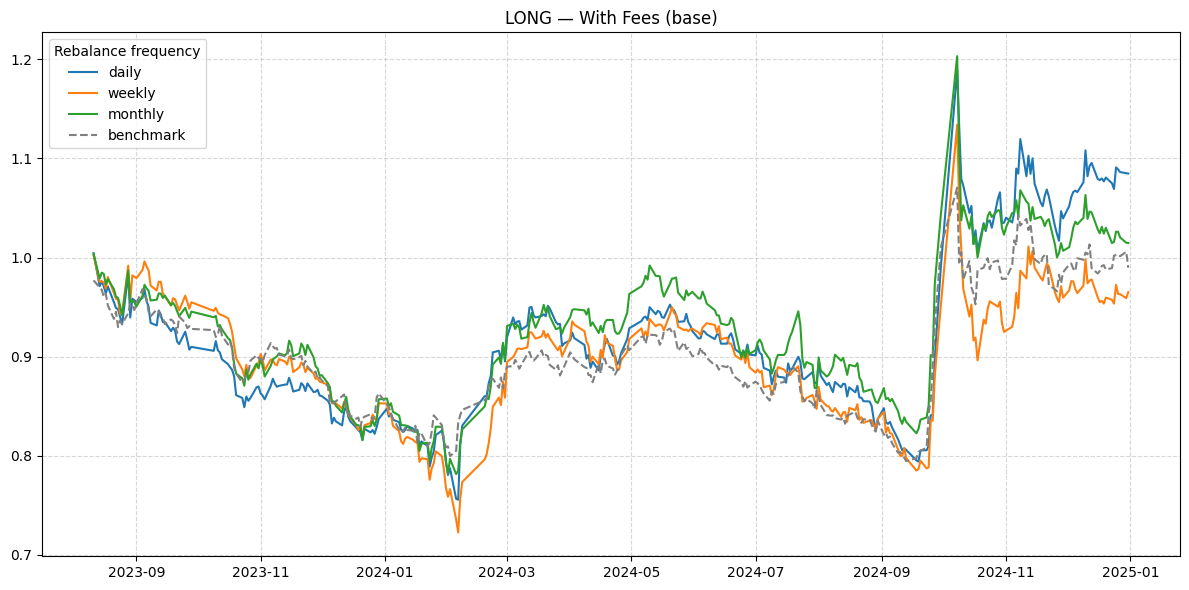


📊 T-Sharpe (60d) Rolling Sharpe Summary:
mean    0.030562
std     0.136930
min    -0.324203
10%    -0.139785
25%    -0.066923
50%     0.016899
75%     0.123579
90%     0.210993
max     0.437621


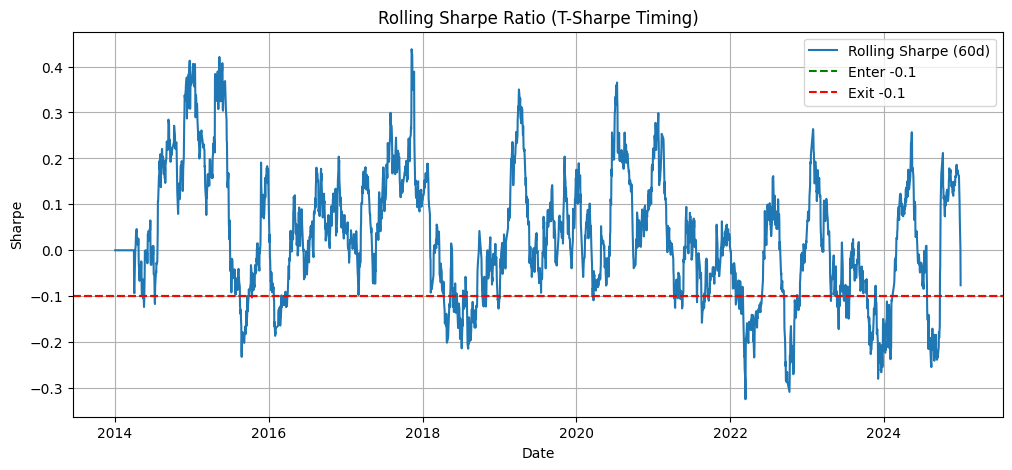


🔍 T-Sharpe describe (for threshold tuning):
mean    0.030562
std     0.136930
min    -0.324203
10%    -0.139785
25%    -0.066923
50%     0.016899
75%     0.123579
90%     0.210993
max     0.437621


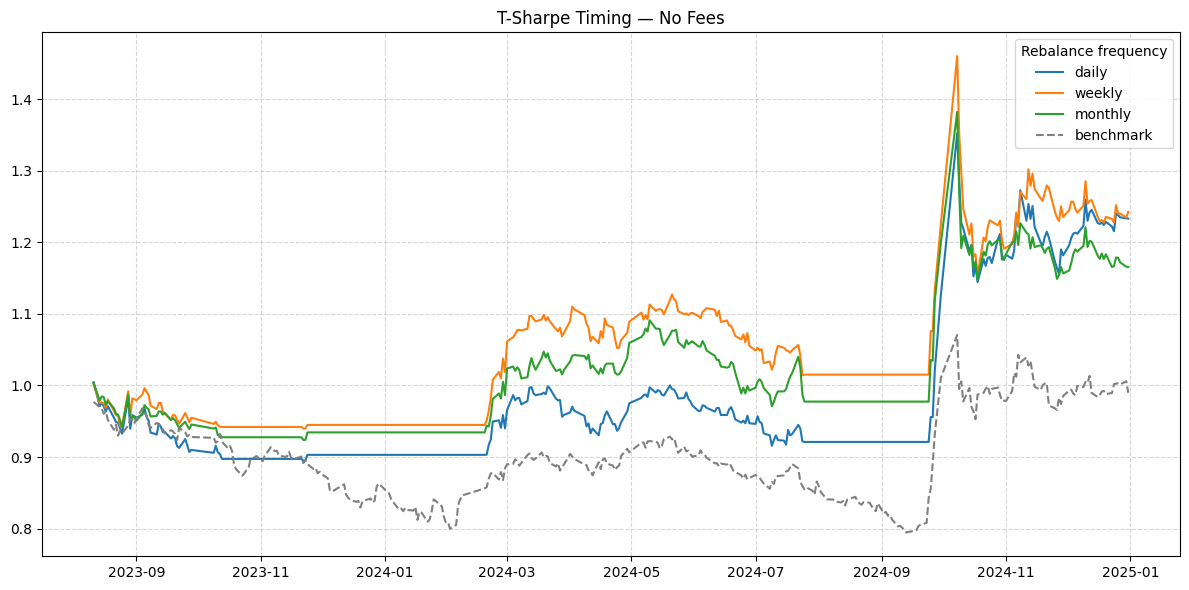

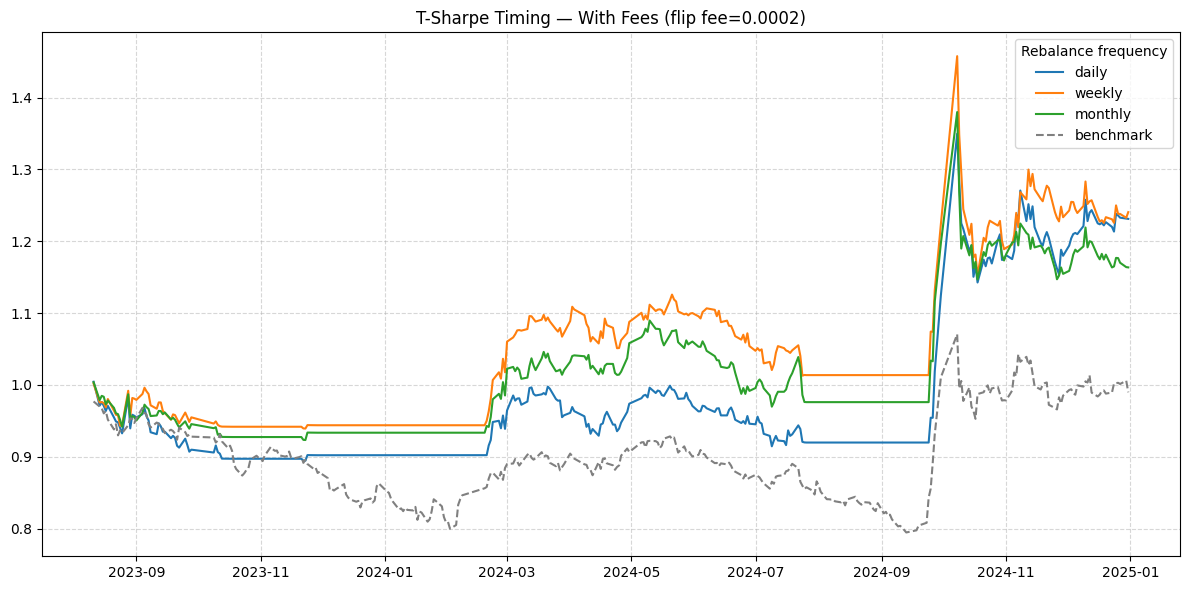


=== 📊 Performance Summary (T-Sharpe Gross) ===


,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
5d,17.627829,26.393792,0.667878,-20.960504
1d,16.962556,26.886081,0.630905,-15.341874
22d,12.130355,23.929858,0.506913,-16.887448
Benchmark,5.092629,21.953205,0.231977,-46.696135



=== 📊 Performance Summary (T-Sharpe Net) ===


,Annual Return %,Volatility %,Sharpe,Max Drawdown %
Strategy,,,,
5d,17.488329,26.390226,0.662682,-20.960504
1d,16.823436,26.883990,0.625779,-15.341874
22d,11.997495,23.925362,0.501455,-16.887448
Benchmark,5.092629,21.953205,0.231977,-46.696135



=== 📈 Alpha / Beta (T-Sharpe Net) ===
📂 已读取无风险利率文件: 10Y_CN_Treasury.csv (共 1394 行)
🧭 检测到无风险利率列: Risk Free rate
🛠️ 检测到 RF 单位为百分比（例如 2.73%），自动 /100 转为十进制。
✅ 无风险利率读取成功，共 1394 条记录。示例: 年化≈2.73 → 日化≈0.000126

🔎 1d 量纲检查: mean(strategy)=0.000752, std(strategy)=0.016935; mean(bench)=0.000044, std(bench)=0.012270; mean(rf)=0.000093

📈 1d CAPM 回归摘要：
                            OLS Regression Results                            
Dep. Variable:        excess_strategy   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     54.00
Date:                 周二, 28 10月 2025   Prob (F-statistic):           1.55e-12
Time:                        14:43:07   Log-Likelihood:                 921.89
No. Observations:                 337   AIC:                            -1840.
Df Residuals:                     335   BIC:                            -1832.
Df Model:                 

,Alpha (daily),"Alpha (annual %, linear)","Alpha (annual %, geom)",Beta,Alpha t-value,Beta t-value,Alpha p-value,Beta p-value,R²,Samples
Strategy,,,,,,,,,,
5d,0.000703,17.71,19.37,0.501,0.83,7.29,4.048e-01,2.251e-12,0.137,337
1d,0.000685,17.25,18.82,0.514,0.80,7.35,4.252e-01,1.547e-12,0.139,337
22d,0.000489,12.32,13.11,0.452,0.64,7.24,5.230e-01,3.130e-12,0.135,337


In [98]:
gross, net, tsh_gross, tsh_net = run_rebalance_comparison_with_tsharpe(
    panel=panel,
    factor_cols=factor_cols,
    benchmark_returns=bm_daily_ret,
    rebalance_list=[1, 5, 22],
    portfolio_percentile=7,
    fee_per_side_total=0.0002,
    mode="long",
    rf_csv_path="10Y_CN_Treasury.csv",
    tsh_lookback=60,
    tsh_enter=-0.1,
    tsh_exit=-0.1,
    fee_per_flip=0.0002
)
